In [66]:
# Imports and setup
import sys
from pathlib import Path
from collections import Counter, defaultdict

import matplotlib.pyplot as plt

REPO_ROOT = Path('..').resolve()
if str(REPO_ROOT) not in sys.path:
    sys.path.append(str(REPO_ROOT))

from utils.data_processing import DataProcessor, SWITCH_TOKEN, TERMINATION_TOKEN

plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 300


In [67]:
# Load and process the data
data_path = REPO_ROOT / 'data' / 'data.xlsx'

dp = DataProcessor()
dp.load_excel(str(data_path))
sessions = dp.sessions

print(f"Data loaded: {len(sessions)} sessions from {data_path.name}")


Data loaded: 1108 sessions from data.xlsx


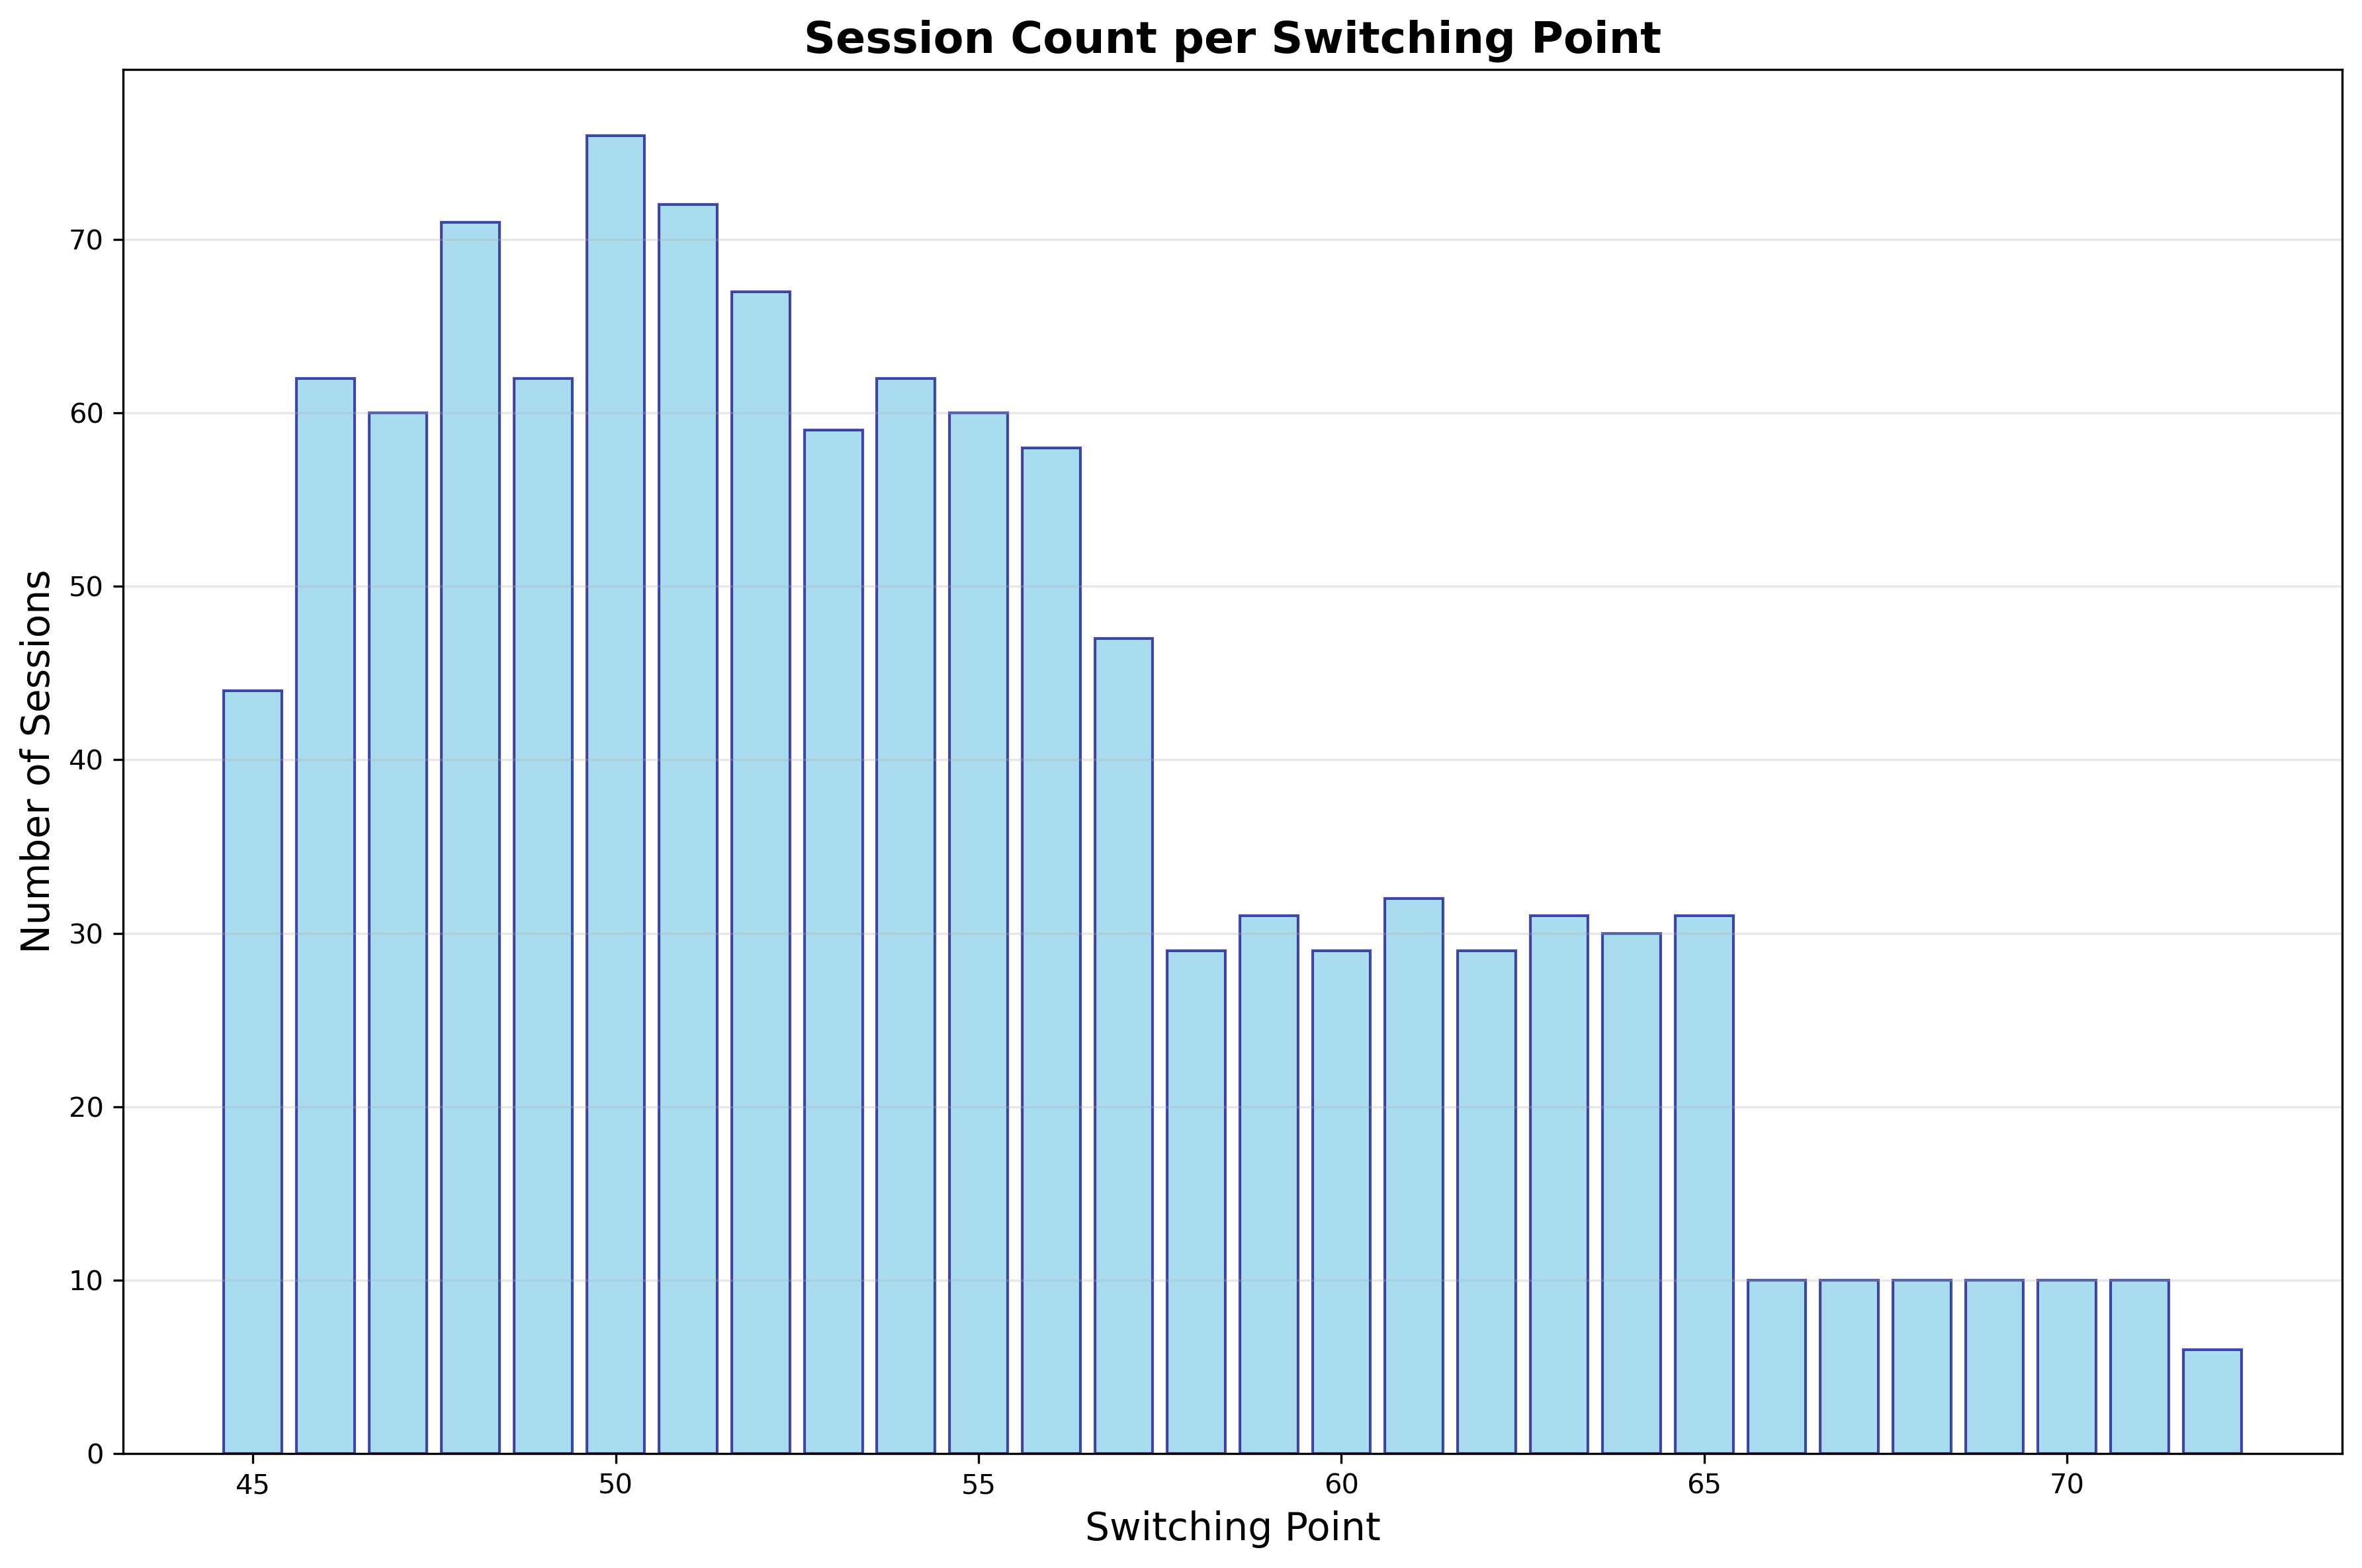

In [68]:
# Plot 1: Cluster Histogram
switch_points = [s.switch_point for s in sessions if s.switch_point is not None]

sp_counts = Counter(switch_points)
labels = sorted(sp_counts.keys())
values = [sp_counts[sp] for sp in labels]

plt.figure(figsize=(12, 8))
plt.bar(labels, values, alpha=0.7, color='skyblue', edgecolor='navy')
plt.title('Session Count per Switching Point', fontsize=16, fontweight='bold')
plt.xlabel('Switching Point', fontsize=14)
plt.ylabel('Number of Sessions', fontsize=14)
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('cluster_histogram.png', dpi=300, bbox_inches='tight')
plt.show()


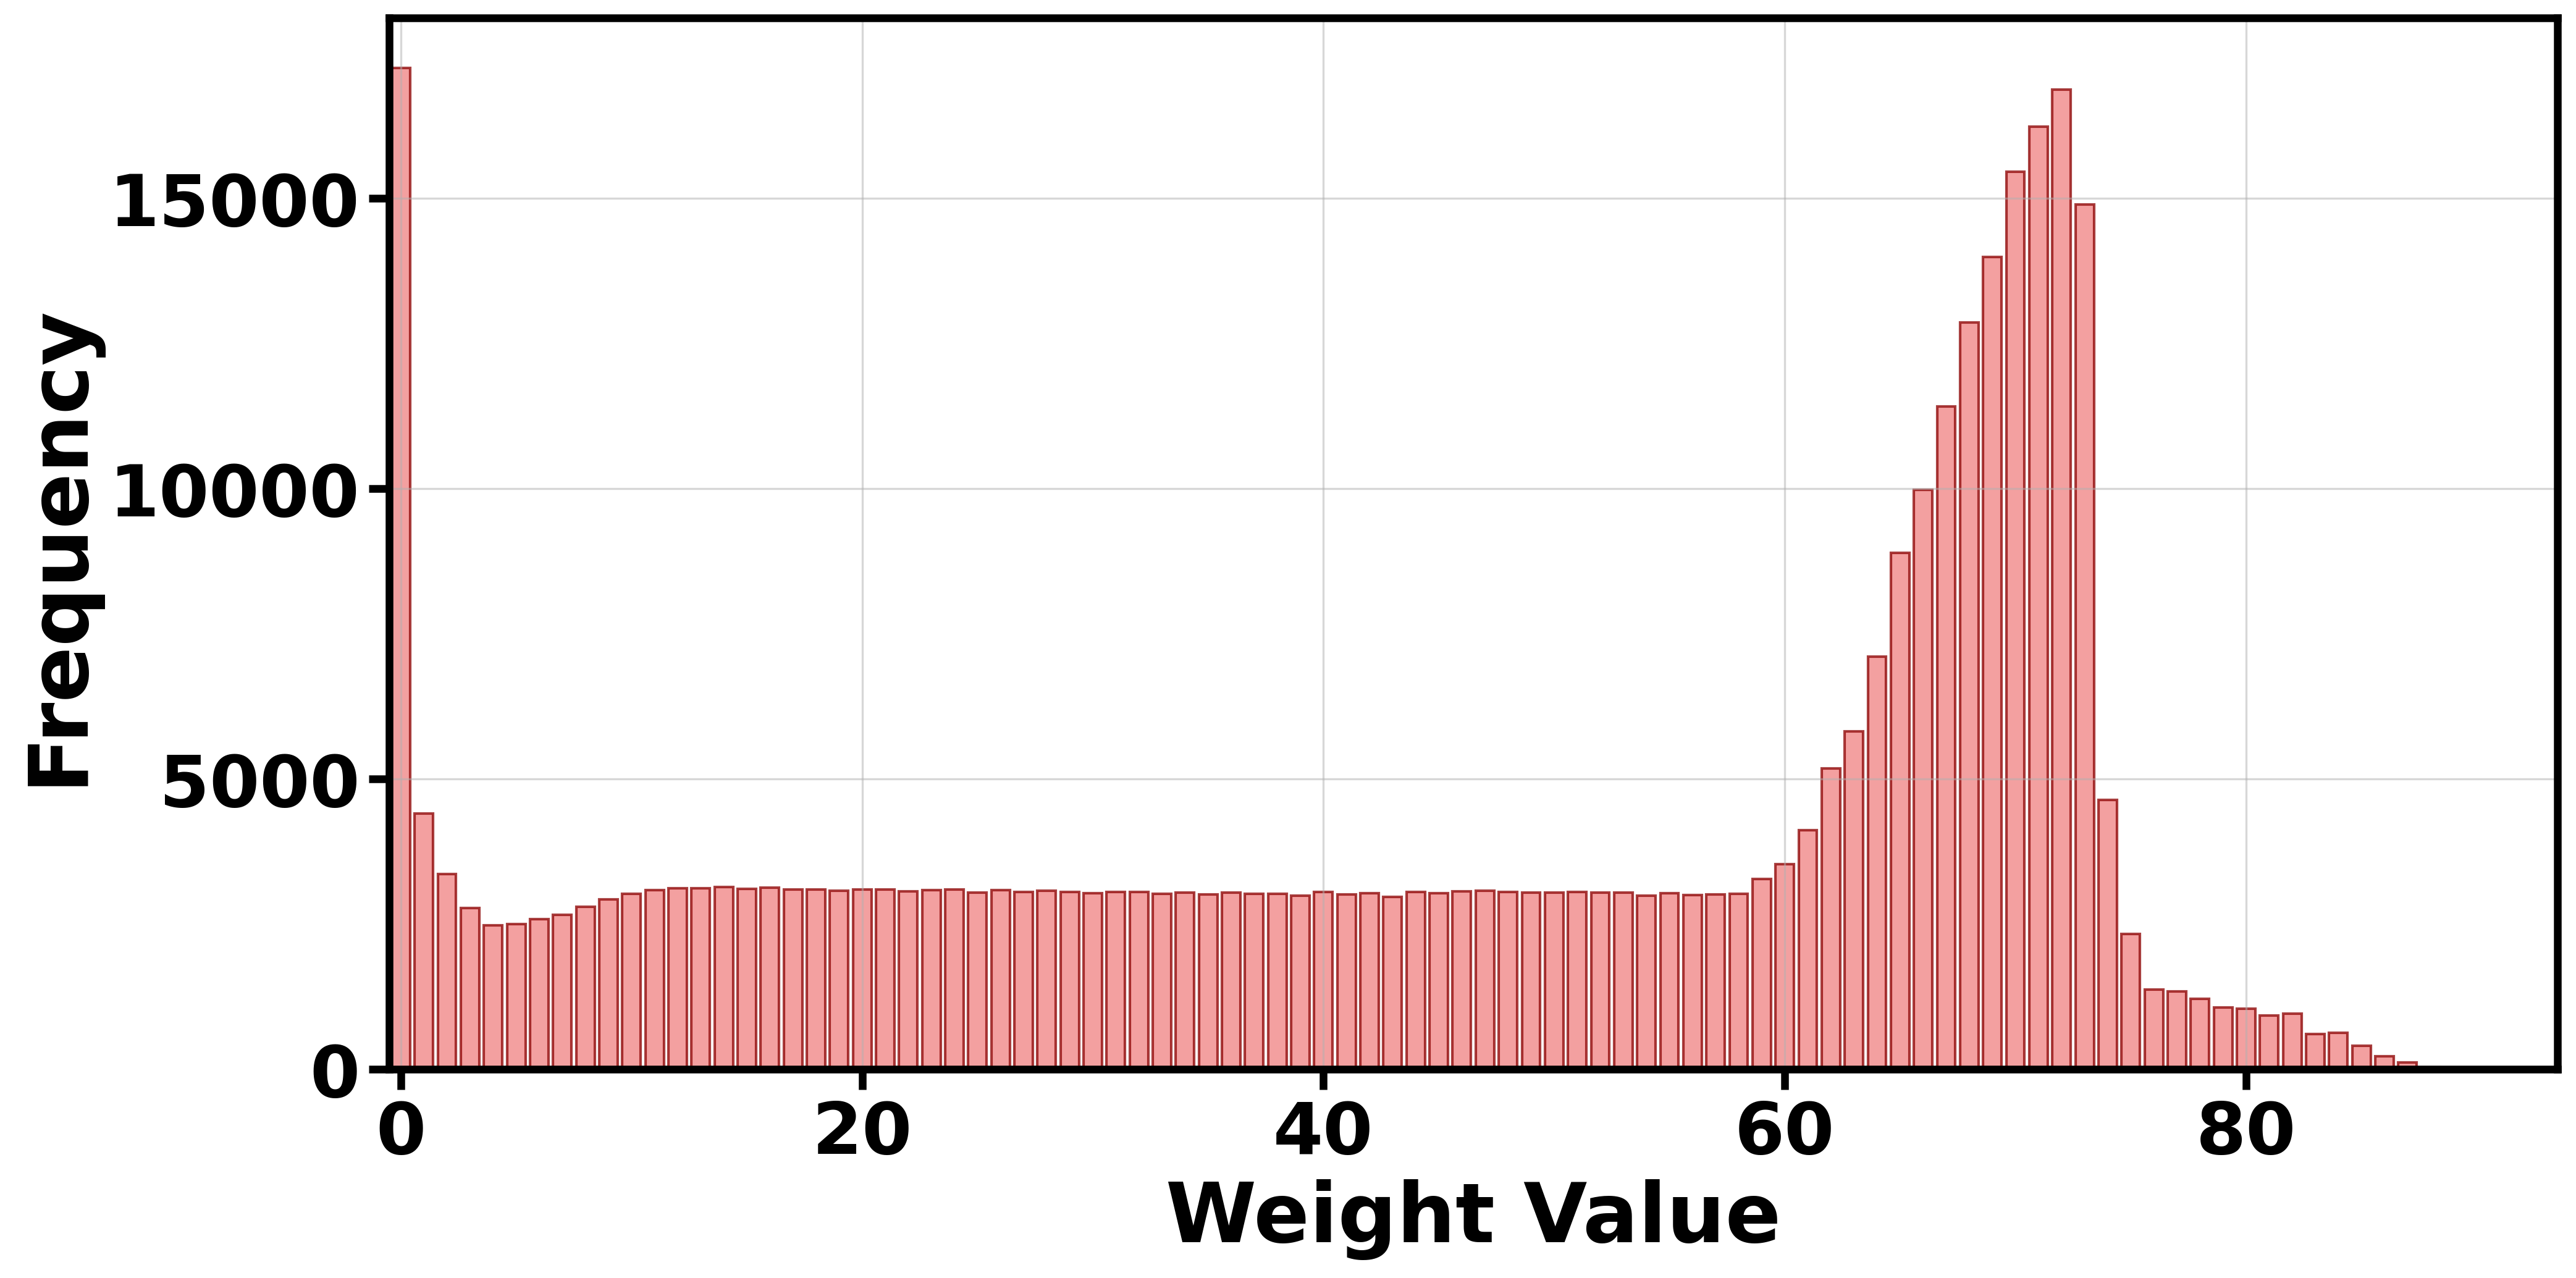

In [69]:
# Plot 2: Weight Count Histogram
all_weights = []
for session in sessions:
    for weight in session.weight_sequence:
        if weight not in (SWITCH_TOKEN, TERMINATION_TOKEN):
            all_weights.append(weight)

weight_counter = Counter(all_weights)
weights = sorted(weight_counter.keys())
counts = [weight_counter[w] for w in weights]

fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(weights, counts, alpha=0.75, color='lightcoral', edgecolor='darkred')
ax.set_xlabel('Weight Value', fontsize=32, fontweight='bold')
ax.set_ylabel('Frequency', fontsize=32, fontweight='bold')
ax.set_xlim(weights[0] - 0.5, weights[-1] + 0.5)
ax.grid(True, axis='both', alpha=0.5)
ax.tick_params(axis='both', width=3, length=8, labelsize=28)
for spine in ax.spines.values():
    spine.set_linewidth(3)
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontweight('bold')
fig.tight_layout()
fig.savefig('weight_count_histogram.png', dpi=600, bbox_inches='tight')
plt.show()

In [70]:
# Average episode length by switch point
lengths = defaultdict(list)
for session in sessions:
    if session.switch_point is None:
        continue
    lengths[session.switch_point].append(session.episode_length)

print('switch_point\tavg_length\tsessions')
for sp in sorted(lengths):
    runs = lengths[sp]
    avg = sum(runs) / len(runs)
    print(f'{sp}\t{avg:.2f}\t{len(runs)}')


switch_point	avg_length	sessions
45	451.73	44
46	435.40	62
47	424.45	60
48	411.34	71
49	372.65	62
50	388.97	76
51	334.14	72
52	347.99	67
53	319.56	59
54	311.10	62
55	277.00	60
56	277.16	58
57	258.77	47
58	240.76	29
59	241.77	31
60	249.24	29
61	233.19	32
62	233.14	29
63	239.48	31
64	247.23	30
65	253.26	31
66	243.50	10
67	283.50	10
68	276.20	10
69	264.30	10
70	278.50	10
71	295.70	10
72	267.17	6


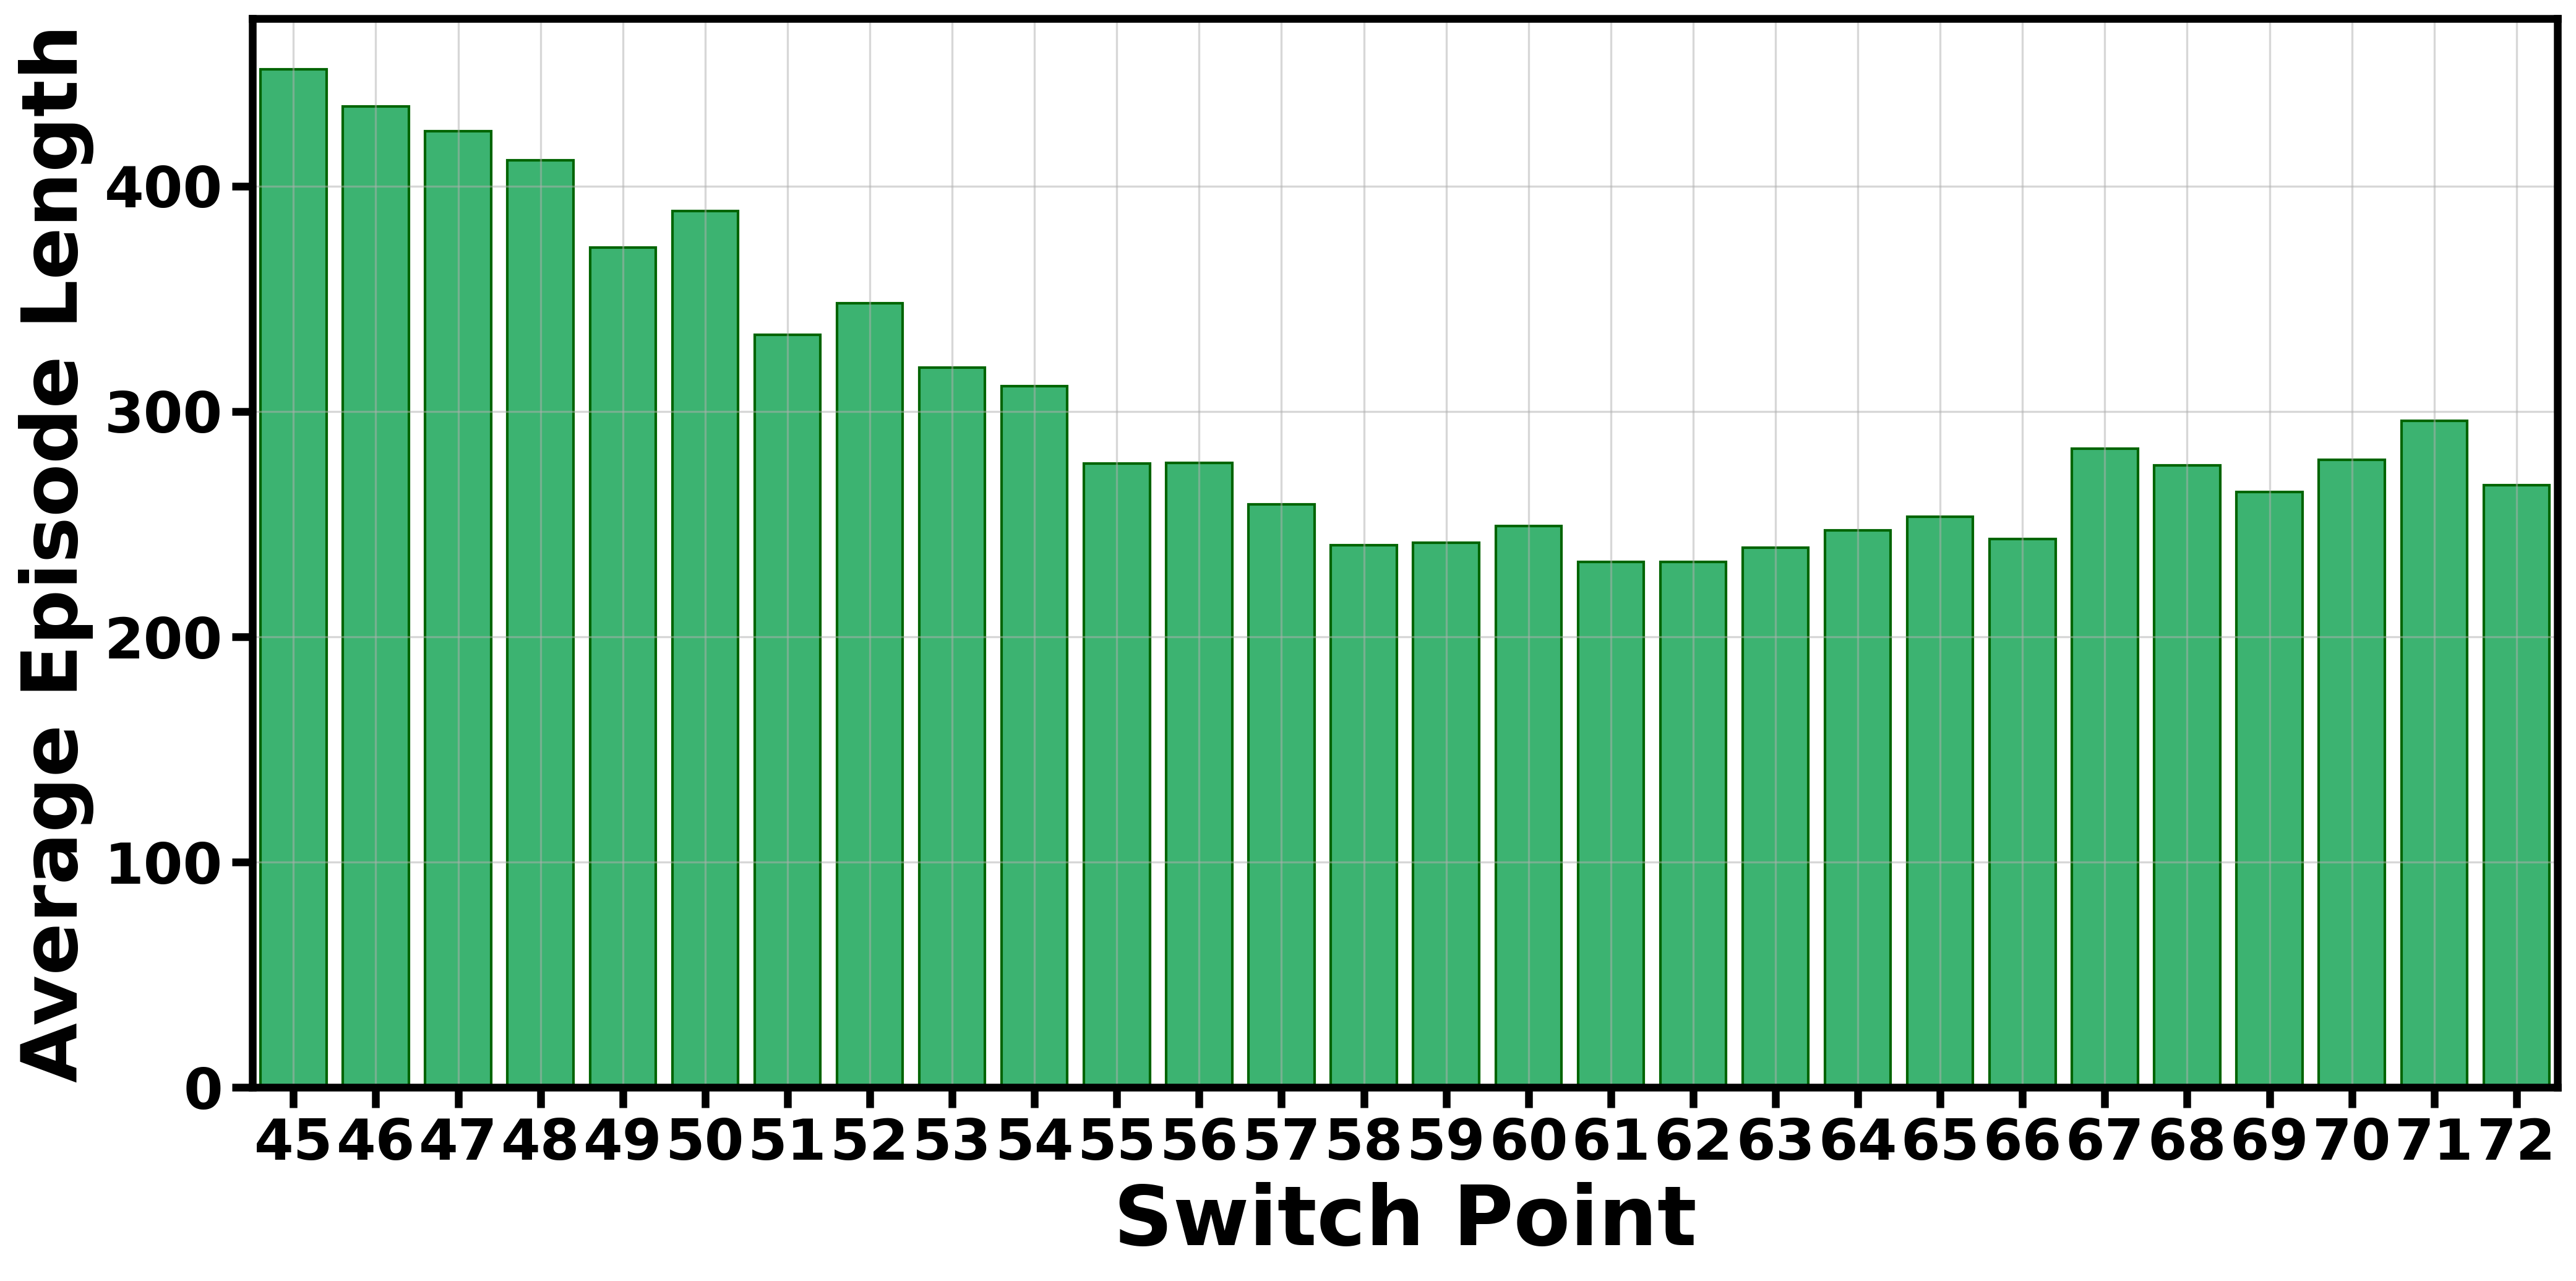

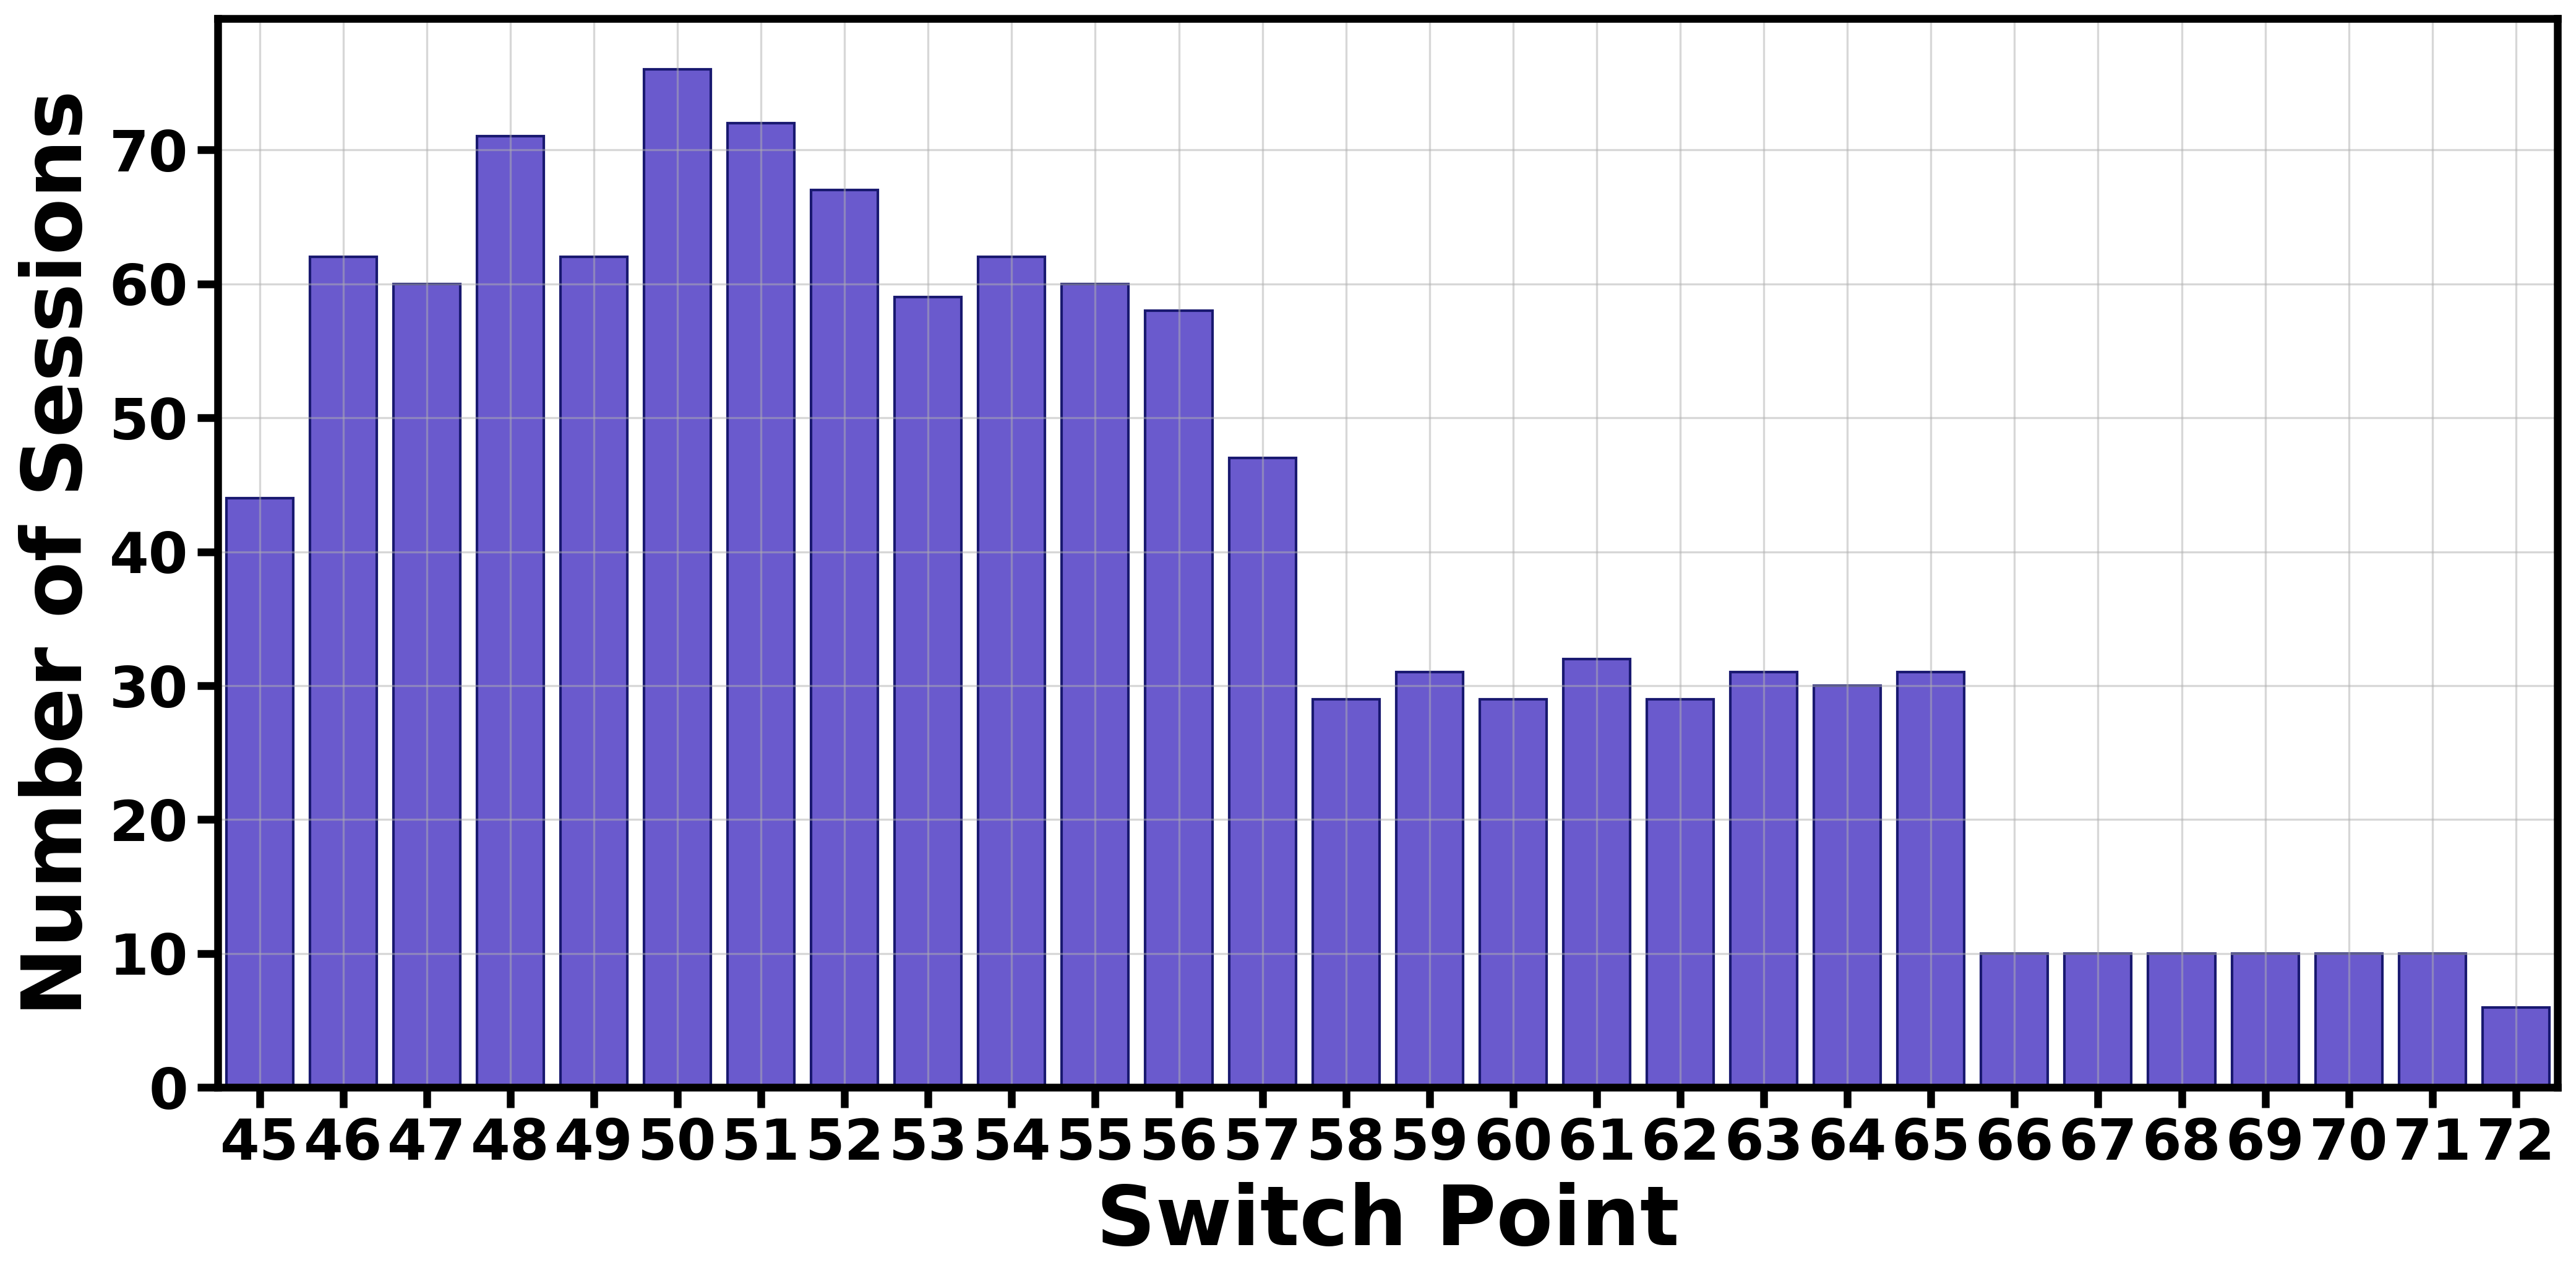

In [71]:
# Plot 3: Average episode length per switch point
avg_lengths = []
counts = []
labels = []
for sp in sorted(lengths):
    runs = lengths[sp]
    avg_lengths.append(sum(runs) / len(runs))
    counts.append(len(runs))
    labels.append(sp)

fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(labels, avg_lengths, color='mediumseagreen', edgecolor='darkgreen')
ax.set_xlabel('Switch Point', fontsize=32, fontweight='bold')
ax.set_ylabel('Average Episode Length', fontsize=30, fontweight='bold')
ax.set_xticks(labels)
ax.set_xlim(labels[0] - 0.5, labels[-1] + 0.5)
ax.grid(True, axis='both', alpha=0.5)
ax.tick_params(axis='both', width=3, length=8, labelsize=22)
for spine in ax.spines.values():
    spine.set_linewidth(3)
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontweight('bold')
fig.tight_layout()
fig.savefig('avg_episode_length_by_switch.png', dpi=600, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(labels, counts, color='slateblue', edgecolor='midnightblue')
ax.set_xlabel('Switch Point', fontsize=32, fontweight='bold')
ax.set_ylabel('Number of Sessions', fontsize=32, fontweight='bold')
ax.set_xticks(labels)
ax.set_xlim(labels[0] - 0.5, labels[-1] + 0.5)
ax.grid(True, axis='both', alpha=0.5)
ax.tick_params(axis='both', width=3, length=8, labelsize=22)
for spine in ax.spines.values():
    spine.set_linewidth(3)
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontweight('bold')
fig.tight_layout()
fig.savefig('session_counts_by_switch.png', dpi=600, bbox_inches='tight')
plt.show()

In [72]:
from collections import Counter
import numpy as np

dp = DataProcessor()
dp.load_excel("../data/data.xlsx")

durations = []
switch_points = []
final_weights = []
overflow = 0
underflow = 0

safe_min, safe_max = 740, 760  # adjust if tolerance differs

for sessions in dp.switch_point_clusters.values():
    for session in sessions:
        durations.append(session.episode_length * 0.01)      # 10 ms -> seconds
        switch_points.append(session.switch_point * 10)       # decigrams -> grams
        final_weights.append(session.final_weight * 10)       # decigrams -> grams
        if session.final_weight * 10 > safe_max:
            overflow += 1
        elif session.final_weight * 10 < safe_min:
            underflow += 1

durations = np.array(durations)
switch_points = np.array(switch_points)
final_weights = np.array(final_weights)

print(f"Total fillings: {len(durations)}")
print(f"Average fill time: {durations.mean():.2f} s ± {durations.std():.2f} s")
print(f"Average switch point: {switch_points.mean():.1f} g")
print(f"Average final weight: {final_weights.mean():.1f} g")
print(f"Overflow count (> {safe_max} g): {overflow}")
print(f"Underflow count (< {safe_min} g): {underflow}")

# optional: histograms or additional percentiles
print(f"Median fill time: {np.median(durations):.2f} s")
print(f"90th percentile time: {np.percentile(durations, 90):.2f} s")


Total fillings: 1108
Average fill time: 3.26 s ± 0.97 s
Average switch point: 543.2 g
Average final weight: 767.6 g
Overflow count (> 760 g): 303
Underflow count (< 740 g): 33
Median fill time: 2.95 s
90th percentile time: 4.70 s
